# Data Processing

## SMILES canonicalization and Scaffolding

In [7]:
from pathlib import Path
import os
import pandas as pd

def find_project_root(start: Path | None = None) -> Path:
    """
    Walk upward from `start` (or current working dir) until we find a directory
    that contains either `.git` or `pyproject.toml`. If nothing is found, raise.
    """
    if start is None:
        # In notebooks, __file__ is typically undefined; use CWD safely.
        start = Path.cwd()
    start = start if start.is_dir() else start.parent

    for p in [start, *start.parents]:
        if (p / ".git").exists() or (p / "pyproject.toml").exists():
            return p
    raise RuntimeError(
        f"Could not locate project root above {start}. "
        "Open the notebook from inside the repo or set PROJECT_ROOT env var."
    )

# One-time project root detection per session
if "FIT_PROTEINS_PROJECT_ROOT" in os.environ:
    project_root = Path(os.environ["FIT_PROTEINS_PROJECT_ROOT"]).resolve()
else:
    project_root = find_project_root()
    os.environ["FIT_PROTEINS_PROJECT_ROOT"] = str(project_root)

# Only chdir if not already there (prevents 'creeping upwards' on re-runs)
if Path.cwd().resolve() != project_root:
    os.chdir(project_root)

print("Project root:", project_root)
print("Data dirs exist:",
      (project_root / "data/raw").exists(),
      (project_root / "data/processed").exists())

# Define paths you’ll reuse below
DATA_DIR = project_root / "data/processed"
RAW_DIR  = project_root / "data/raw"



Project root: /Users/fut_payi/Desktop/F.I.T-Proteins
Data dirs exist: True True


In [19]:
train = pd.read_parquet(RAW_DIR / "train_brd4_50k_stratified.parquet")
test  = pd.read_parquet(RAW_DIR / "test_brd4_50k.parquet")

print("Train shape:", train.shape)
train.head()

first_non_zero_bind = train[train['binds'] != 0].iloc[0]
print(first_non_zero_bind)



Train shape: (50000, 7)
id                                                                  367926
protein_name                                                          BRD4
molecule_smiles          C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCc2cnc(N3CCOCC3)...
buildingblock1_smiles      C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21
buildingblock2_smiles                                        Cc1cc(N)ccc1O
buildingblock3_smiles                              NCc1cnc(N2CCOCC2)c(F)c1
binds                                                                    1
Name: 186, dtype: object


In [20]:
# --- quick schema & sanity scan (one cell) ---

import numpy as np

def exists(df, col): 
    return col in df.columns

def describe_frame(df, name):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("\ncolumns & dtypes:")
    print(df.dtypes)

    print("\nnull counts (top 20):")
    print(df.isna().sum().sort_values(ascending=False).head(20))

    # Basic peek without assuming column names
    print("\nhead():")
    print(df.head(3))

    # If 'binds' exists, summarize it
    if exists(df, 'binds'):
        vc = df['binds'].value_counts(dropna=False)
        print("\n'binds' value_counts (top 10):")
        print(vc.head(10))
        # Try to infer binary/non-binary quickly
        try:
            arr = df['binds'].to_numpy()
            print("binds dtype:", arr.dtype, "| unique (up to 10):", np.unique(arr)[:10])
        except Exception as e:
            print("could not inspect binds array:", e)

    # If SMILES exists, check for linker tokens and example length distribution
    for col in ['smiles', 'molecule_smiles', 'smiles_no_linker']:
        if exists(df, col):
            s = df[col].astype(str)
            print(f"\n'{col}' presence checks:")
            print("  contains '[Dy]':", s.str.contains(r'\[Dy\]', regex=True, na=False).any())
            print("  example values:", s.head(3).tolist())
            print("  length stats (chars):", s.str.len().describe())

    # If building-block columns exist, show quick uniqueness
    bb_cols = [c for c in df.columns if c.lower().startswith('block')]
    if bb_cols:
        print("\nblock columns found:", bb_cols)
        for c in bb_cols:
            print(f"  {c}: n_unique={df[c].nunique(dropna=False)}")

describe_frame(train, "TRAIN")
describe_frame(test,  "TEST")



=== TRAIN ===
shape: (50000, 7)

columns & dtypes:
id                        int64
protein_name             object
molecule_smiles          object
buildingblock1_smiles    object
buildingblock2_smiles    object
buildingblock3_smiles    object
binds                     uint8
dtype: object

null counts (top 20):
id                       0
protein_name             0
molecule_smiles          0
buildingblock1_smiles    0
buildingblock2_smiles    0
buildingblock3_smiles    0
binds                    0
dtype: int64

head():
      id protein_name                                    molecule_smiles  \
0   9051         BRD4  C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCOCC(=C)C)nc(Nc...   
1  71760         BRD4  C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCC2OCCC2(C)C)nc...   
2  92688         BRD4  C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCC(C)(O)CC)nc(N...   

                             buildingblock1_smiles buildingblock2_smiles  \
0  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21        C=C(C)COCCN.Cl   
1  C#CC[C@@H](CC(=O

In [21]:
# -- make a canonical, linker-free SMILES column ('smiles_clean') --

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

def clean_smiles(s: str) -> str | None:
    # Replace DEL linker token, then canonicalize (preserve stereochemistry)
    s2 = s.replace('[Dy]', '[H]')
    mol = Chem.MolFromSmiles(s2)
    if mol is None:
        return None
    # Sanitize & canonicalize with iso SMILES
    Chem.SanitizeMol(mol, catchErrors=True)
    return Chem.MolToSmiles(mol, isomericSmiles=True)

# Apply to TRAIN / TEST
train['smiles_clean'] = train['molecule_smiles'].astype(str).map(clean_smiles)
test['smiles_clean']  = test['molecule_smiles'].astype(str).map(clean_smiles)

# Quick sanity report
print("train smiles_clean nulls:", train['smiles_clean'].isna().sum())
print("test  smiles_clean nulls:", test['smiles_clean'].isna().sum())

changed_train = (train['smiles_clean'] != train['molecule_smiles']).sum()
changed_test  = (test['smiles_clean']  != test['molecule_smiles']).sum()
print("changed (train):", changed_train, "| changed (test):", changed_test)

print("\nexamples (train):")
print(train[['molecule_smiles','smiles_clean']].head(5).to_string(index=False))

print("\nlength stats (chars) on smiles_clean (train):")
print(train['smiles_clean'].str.len().describe())


train smiles_clean nulls: 0
test  smiles_clean nulls: 0
changed (train): 50000 | changed (test): 50000

examples (train):
                                                            molecule_smiles                                                            smiles_clean
                 C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCOCC(=C)C)nc(Nc2cccnc2OC)n1                  C#CC[C@@H](CC(N)=O)Nc1nc(NCCOCC(=C)C)nc(Nc2cccnc2OC)n1
     C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCC2OCCC2(C)C)nc(NCC(C)c2c(Cl)cccc2Cl)n1      C#CC[C@@H](CC(N)=O)Nc1nc(NCCC2OCCC2(C)C)nc(NCC(C)c2c(Cl)cccc2Cl)n1
              C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCC(C)(O)CC)nc(Nc2cc(Br)ccn2)n1               C#CC[C@@H](CC(N)=O)Nc1nc(NCCC(C)(O)CC)nc(Nc2cc(Br)ccn2)n1
                      C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCCOCC)nc(NCC2CCCOC2)n1                       C#CC[C@@H](CC(N)=O)Nc1nc(NCCCOCC)nc(NCC2CCCOC2)n1
C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCc2nnc(C(C)(C)C)s2)nc(Nc2ccnc(-c3ccccc3)c2)n1 C#CC[C@@H](CC(N)=O)Nc1nc(NCc2nnc(C(C)(C)C)s2)nc(Nc2ccnc(-c3ccc

In [22]:
# --- add canonical building blocks + group flag (shared vs non-shared) ---

from pathlib import Path
import pandas as pd
from rdkit import Chem

PROJECT_ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd()
PROC = PROJECT_ROOT / "data" / "processed"

train = pd.read_parquet(PROC / "train_brd4_50k_clean.parquet")
test  = pd.read_parquet(PROC / "test_brd4_50k_clean.parquet")

bb_cols = ["buildingblock1_smiles","buildingblock2_smiles","buildingblock3_smiles"]

def canon_block(s: str) -> str | None:
    if not isinstance(s, str):
        return None
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        return None
    Chem.SanitizeMol(mol, catchErrors=True)
    return Chem.MolToSmiles(mol, isomericSmiles=True)

# canonicalize blocks on both splits
for c in bb_cols:
    train[c+"_clean"] = train[c].astype(str).map(canon_block)
    test[c+"_clean"]  = test[c].astype(str).map(canon_block)

# build the test-block set for membership checks
test_blocks = set()
for c in bb_cols:
    test_blocks |= set(test[c+"_clean"].dropna().unique().tolist())

# flag train rows that share at least one block with test
def any_shared_blocks(row) -> bool:
    return any((row[c+"_clean"] in test_blocks) for c in bb_cols)

train["shared_block_any"] = train.apply(any_shared_blocks, axis=1)

# tiny report
print("train size:", len(train))
print("shared_block_any value_counts:")
print(train["shared_block_any"].value_counts(dropna=False))

print("\npreview columns:")
cols_show = ["id","binds","smiles_clean","shared_block_any"] + [c+"_clean" for c in bb_cols]
print(train[cols_show].head(3).to_string(index=False))

# (not writing yet — we'll confirm before persisting)


train size: 50000
shared_block_any value_counts:
shared_block_any
True    50000
Name: count, dtype: int64

preview columns:
   id  binds                                                       smiles_clean  shared_block_any                     buildingblock1_smiles_clean buildingblock2_smiles_clean buildingblock3_smiles_clean
 9051      0             C#CC[C@@H](CC(N)=O)Nc1nc(NCCOCC(=C)C)nc(Nc2cccnc2OC)n1              True C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21              C=C(C)COCCN.Cl                 COc1ncccc1N
71760      0 C#CC[C@@H](CC(N)=O)Nc1nc(NCCC2OCCC2(C)C)nc(NCC(C)c2c(Cl)cccc2Cl)n1              True C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21              CC1(C)CCOC1CCN        CC(CN)c1c(Cl)cccc1Cl
92688      0          C#CC[C@@H](CC(N)=O)Nc1nc(NCCC(C)(O)CC)nc(Nc2cc(Br)ccn2)n1              True C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21                CCC(C)(O)CCN               Nc1cc(Br)ccn1


In [27]:
# --- create *_clean block columns if missing, then make OOD split by holding out blocks (5%) ---

import numpy as np
import pandas as pd
from pathlib import Path
from rdkit import Chem

PROJECT_ROOT = Path.cwd()
PROC = PROJECT_ROOT / "data" / "processed"

train = pd.read_parquet(PROC / "train_brd4_50k_clean.parquet")
test  = pd.read_parquet(PROC / "test_brd4_50k_clean.parquet")

bb_cols   = ["buildingblock1_smiles","buildingblock2_smiles","buildingblock3_smiles"]
bb_clean  = [c + "_clean" for c in bb_cols]

def canon_block(s: str) -> str | None:
    if not isinstance(s, str):
        return None
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        return None
    Chem.SanitizeMol(mol, catchErrors=True)
    return Chem.MolToSmiles(mol, isomericSmiles=True)

# add *_clean columns if missing
for c, cc in zip(bb_cols, bb_clean):
    if cc not in train.columns:
        train[cc] = train[c].astype(str).map(canon_block)
    if cc not in test.columns:
        test[cc]  = test[c].astype(str).map(canon_block)

# build universe of unique blocks from TRAIN ONLY (so val OOD is internal to train)
train_blocks = set().union(*[set(train[cc].dropna().unique()) for cc in bb_clean])
train_blocks = np.array(list(train_blocks))

# choose 5% blocks to hold out (deterministic seed)
rng = np.random.default_rng(42)
k = max(1, int(0.05 * len(train_blocks)))
held_out_blocks = set(rng.choice(train_blocks, size=k, replace=False))

# flag OOD rows: any held-out block present -> goes to validation
def any_held_out(row) -> bool:
    return any((row[cc] in held_out_blocks) for cc in bb_clean)

train["split_group"] = np.where(train.apply(any_held_out, axis=1), "val_ood", "train_in")

# small report
print("unique blocks (train):", len(train_blocks))
print("held-out blocks       :", len(held_out_blocks))
print("\nsplit_group counts:")
print(train["split_group"].value_counts())

if "binds" in train.columns:
    agg = train.groupby("split_group")["binds"].agg(["count","sum","mean"])
    agg = agg.rename(columns={"sum":"positives","mean":"pos_rate"})
    print("\nlabel stats by split_group:")
    print(agg)

# preview
show_cols = ["id","binds","smiles_clean","split_group"] + bb_clean
print("\npreview:")
print(train[show_cols].head(5).to_string(index=False))



unique blocks (train): 872
held-out blocks       : 43

split_group counts:
split_group
train_in    45726
val_ood      4274
Name: count, dtype: int64

label stats by split_group:
             count  positives  pos_rate
split_group                            
train_in     45726        252  0.005511
val_ood       4274         17  0.003978

preview:
    id  binds                                                            smiles_clean split_group                     buildingblock1_smiles_clean buildingblock2_smiles_clean buildingblock3_smiles_clean
  9051      0                  C#CC[C@@H](CC(N)=O)Nc1nc(NCCOCC(=C)C)nc(Nc2cccnc2OC)n1    train_in C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21              C=C(C)COCCN.Cl                 COc1ncccc1N
 71760      0      C#CC[C@@H](CC(N)=O)Nc1nc(NCCC2OCCC2(C)C)nc(NCC(C)c2c(Cl)cccc2Cl)n1    train_in C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21              CC1(C)CCOC1CCN        CC(CN)c1c(Cl)cccc1Cl
 92688      0               C#CC[C@@H](CC(N)=O

In [28]:
# -- persist OOD split + canonical block cols to data/processed --

from pathlib import Path
import pandas as pd
import joblib

PROJECT_ROOT = Path.cwd()
PROC = PROJECT_ROOT / "data" / "processed"

# we reuse the in-memory 'train' and 'test' DataFrames from the previous cell
# (they already have *_clean cols and train['split_group'])

TRAIN_OUT = PROC / "train_brd4_50k_clean_blocks.parquet"
TEST_OUT  = PROC / "test_brd4_50k_clean_blocks.parquet"
META_OUT  = PROC / "chemistry_blocks_metadata.joblib"

# write parquet files
train.to_parquet(TRAIN_OUT, index=False)
test.to_parquet(TEST_OUT, index=False)

# write metadata (held_out_blocks came from previous cell; keep as list for portability)
meta = {
    "bb_clean_cols": ["buildingblock1_smiles_clean",
                      "buildingblock2_smiles_clean",
                      "buildingblock3_smiles_clean"],
    "split_col": "split_group",
    "held_out_blocks": sorted(list(held_out_blocks)),
    "held_out_pct": 0.05,
    "rng_seed": 42,
    "source_train": str((PROC / "train_brd4_50k_clean.parquet").resolve()),
    "source_test":  str((PROC / "test_brd4_50k_clean.parquet").resolve()),
    "outputs": {
        "train": str(TRAIN_OUT.resolve()),
        "test":  str(TEST_OUT.resolve()),
    },
}
joblib.dump(meta, META_OUT)

print("Wrote:")
print(" ", TRAIN_OUT.name)
print(" ", TEST_OUT.name)
print(" ", META_OUT.name)

# tiny confirmation
print("\ncheck columns present:", set(["split_group"] + meta["bb_clean_cols"]).issubset(train.columns))
print("split_group counts:")
print(train["split_group"].value_counts())


Wrote:
  train_brd4_50k_clean_blocks.parquet
  test_brd4_50k_clean_blocks.parquet
  chemistry_blocks_metadata.joblib

check columns present: True
split_group counts:
split_group
train_in    45726
val_ood      4274
Name: count, dtype: int64


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count positives and negatives
bind_counts = train["binds"].value_counts().sort_index()

plt.figure(figsize=(5, 4))
ax = sns.barplot(
    x=bind_counts.index.map({0: "Non-binding", 1: "Binding"}),
    y=bind_counts.values,
    palette=["#4C72B0", "#C44E52"]
)

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + (0.01 * max(bind_counts.values)),
        f"{height / bind_counts.sum() * 100:.2f}%",
        ha="center", va="bottom", fontsize=10
    )
plt.title("BRD4 Molecule Binding Distribution (%)", fontsize=13)
plt.ylabel("Count")
plt.xlabel("")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Print precise ratio
pos_frac = train["binds"].mean()
print(f"✅ Binding fraction: {pos_frac:.5f}  ({pos_frac*100:.2f}% positive examples)")



KeyboardInterrupt: 

In [24]:
from pathlib import Path
from scipy.sparse import load_npz
import numpy as np
import joblib

PROCESSED_DIR = Path("data/processed")

X_train = load_npz(PROCESSED_DIR / "X_train_full.npz")
y_train = np.load(PROCESSED_DIR / "y_train_full.npy")
ids_train = np.load(PROCESSED_DIR / "ids_train_full.npy")
meta = joblib.load(PROCESSED_DIR / "prep_metadata.joblib")["meta"]

print("✅ Loaded processed data")
print("X_train:", X_train.shape)
print("y_train positives:", y_train.sum(), "/", len(y_train), f"({y_train.mean():.5f})")
print("Feature density:", X_train.count_nonzero() / (X_train.shape[0]*X_train.shape[1]))
print("Metadata:", meta)


✅ Loaded processed data
X_train: (50000, 262145)
y_train positives: 269 / 50000 (0.00538)
Feature density: 0.0009426195426195426
Metadata: {'hash_n_features': 262144, 'ngram_range': (2, 4), 'train_path': '/Users/fut_payi/Desktop/F.I.T-Proteins/data/raw/train_brd4_50k_stratified.parquet', 'feature_blocks': ['hashed_smiles', 'onehot_protein']}


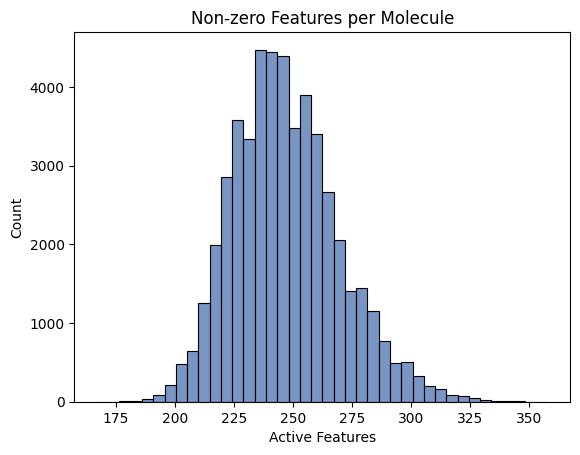

Median non-zero features per molecule: 245.0


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

nz_per_row = X_train.getnnz(axis=1)
sns.histplot(nz_per_row, bins=40, kde=False, color="#4C72B0")
plt.title("Non-zero Features per Molecule")
plt.xlabel("Active Features")
plt.ylabel("Count")
plt.show()

print(f"Median non-zero features per molecule: {np.median(nz_per_row)}")


/var/folders/z4/nl4m_8q17pxg6zl3ln3klpq00000gn/T/ipykernel_25548/3447410108.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="binds", y="nonzero", data=df_summary, palette=["#4C72B0", "#C44E52"])


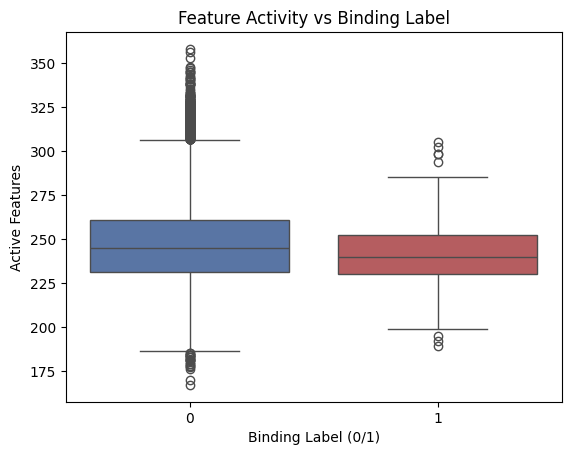

In [26]:
import pandas as pd

df_summary = pd.DataFrame({"binds": y_train, "nonzero": nz_per_row})
sns.boxplot(x="binds", y="nonzero", data=df_summary, palette=["#4C72B0", "#C44E52"])
plt.title("Feature Activity vs Binding Label")
plt.xlabel("Binding Label (0/1)")
plt.ylabel("Active Features")
plt.show()


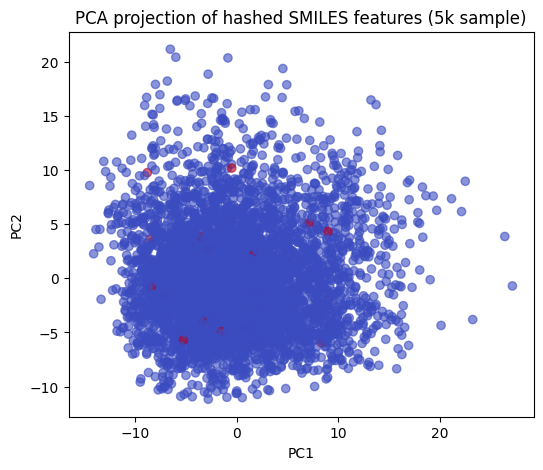

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
X_sample = X_train[:5000].toarray()  # small subset for visualization
y_sample = y_train[:5000]

X_pca = pca.fit_transform(X_sample)
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_sample, cmap="coolwarm", alpha=0.6)
plt.title("PCA projection of hashed SMILES features (5k sample)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score

logreg = LogisticRegression(
    penalty="l2", solver="saga", max_iter=2000, n_jobs=-1, class_weight="balanced"
)
logreg.fit(X_train, y_train)

y_pred_proba = logreg.predict_proba(X_train)[:,1]
print("AUPRC:", average_precision_score(y_train, y_pred_proba))
print("AUROC:", roc_auc_score(y_train, y_pred_proba))


AUPRC: 0.2824733449622449
AUROC: 0.9927370965833358


/Users/fut_payi/Downloads/anaconda3/envs/fit-proteins/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


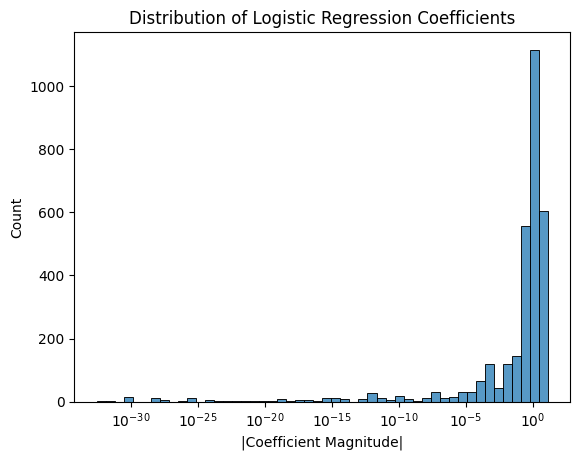

In [29]:
coef_mags = np.abs(logreg.coef_).flatten()
sns.histplot(coef_mags, bins=50, log_scale=True)
plt.title("Distribution of Logistic Regression Coefficients")
plt.xlabel("|Coefficient Magnitude|")
plt.show()
